# Laboratorio 4: KNN

Clase de Alexandre Gramfort, Anne Sabourin, y Joseph Salmon

Actualizado por Valentin Barriere

Integrantes: **José Pablo Canales y Sebastián Salas Lavado**

## Instrucciones

1.  Trabajen en equipos de dos personas. Salvo excepciones, no se corregirá entregas con menos de dos integrantes.

2.  Modifique este archivo `.ipynb` agregando sus respuestas donde corresponda.

3.  Para cada pregunta **incluya el código fuente que utilizó para llegar a su respuesta. Respuestas sin código no recibirán puntaje.**.

4.  El formato de entrega para esta actividad es un archivo **html**. **Genere un archivo HTML usando Jupyter** y súbalo a U-Cursos. Basta con que un/a integrante haga la entrega. Si ambos/as hacen una entrega en U-Cursos, se revisará cualquiera de éstas.


#### **Se recomienda fuertemente que no usen ChatGPT para resolver la actividad, ya que la experiencia de aprendizaje es mucho mayor si lo hacen por su cuenta.**

## Recordatorios  

### Definiciones y Notación

Recordamos aquí el marco de trabajo de la clasificación supervisada y presentamos las notaciones que se utilizarán a lo largo del laboratorio.

- $\mathcal{Y}$ es el conjunto de etiquetas de los datos. Aquí trabajamos con un número arbitrario $L$ de clases, y elegimos $\mathcal{Y} = \{1,\dots, L\}$ para representar las $L$ etiquetas posibles. El caso de clasificación binaria corresponde a $L=2$.  

- $\mathbf{x} = (x_1,\dots,x_p)^\top \in \mathcal{X} \subset \mathbb{R}^p$ es una observación, un ejemplo o un punto de muestra. La $j$-ésima coordenada de $\mathbf{x}$ es el valor tomado por la $j$-ésima variable (característica).  

- $\mathcal{D}_n = \{(\mathbf{x}_i , y_i), i=1,\dots, n\}$ es el conjunto de entrenamiento que contiene los $n$ ejemplos y sus etiquetas.  

- Existe un modelo probabilístico que gobierna la generación de nuestras observaciones a través de las variables aleatorias $X$ e $Y$: $\forall i \in \{1,\dots,n\},  (\mathbf{x}_i , y_i) \stackrel{i.i.d.}{\sim} (X,Y)$.  

- Nuestro objetivo es construir, a partir del conjunto de entrenamiento $\mathcal{D}_n$, una función llamada **clasificador**, $\hat{f}:\mathcal{X} \rightarrow \mathcal{Y}$, que asigne a un nuevo punto $\mathbf{x}_{\text{nuevo}}$ una etiqueta $\hat{f}(\mathbf{x}_{\text{nuevo}})$.

### Generación de Datos Artificiales  

En esta sección, consideramos observaciones descritas en dos dimensiones (para facilitar la visualización), lo que significa que $p=2$ en el formalismo anterior. Utilizamos funciones que generan conjuntos de datos artificiales del script `tp_knn_source.py`, con modificaciones únicamente en los valores de las etiquetas.  

1. **Estudia las funciones `rand_tri_gauss`, `rand_clown` y `rand_checkers`.**  
   - ¿Qué devuelven estas funciones?  
   - ¿A qué corresponde la última columna?

In [11]:
import numpy as np
import matplotlib.pyplot as plt

from tp_knn_source import (rand_gauss, rand_bi_gauss, rand_tri_gauss,
                           rand_checkers, rand_clown, plot_2d,
                           frontiere)

############################################################################
#     Generación de datos
############################################################################

n = 100
mu = [1., 1.]
sigma = [1., 1.]
rand_gauss(n, mu, sigma)

n1 = 20
n2 = 20
mu1 = [1., 1.]
mu2 = [-1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
data1 = rand_bi_gauss(n1, n2, mu1, mu2, sigma1, sigma2)

n1 = 50
n2 = 50
n3 = 50
mu1 = [1., 1.]
mu2 = [-1., -1.]
mu3 = [1., -1.]
sigma1 = [0.9, 0.9]
sigma2 = [0.9, 0.9]
sigma3 = [0.9, 0.9]
data2 = rand_tri_gauss(n1, n2, n3, mu1, mu2, mu3, sigma1, sigma2, sigma3)

n1 = 50
n2 = 50
sigma1 = 1.
sigma2 = 5.
data3 = rand_clown(n1, n2, sigma1, sigma2)

n1 = 150
n2 = 150
sigma = 0.1
data4 = rand_checkers(n1, n2, sigma)

R:
- Las funciones generan puntos (x,y) en las primeras columnas, y la última corresponde a la etiqueta de clase.

rand_tri_gauss: datos provenientes de gaussianas (3 gaussianas).
rand_clown: genera 2 grupos de puntos distribuidos con diferentes ruidos.
rand_checkers: genera patron tipo tablero ajedrez (alternando las clases).


2. Utiliza la función `plot_2d` para visualizar los conjuntos de datos.

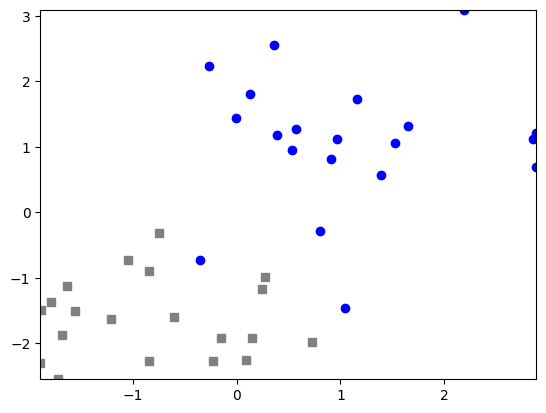

In [12]:
plot_2d(data1, data1[:,2])

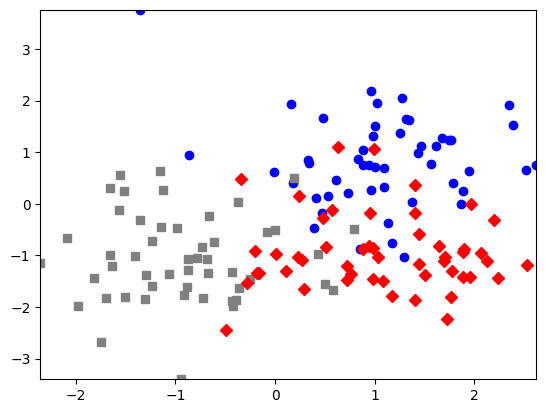

In [13]:
plot_2d(data2, data2[:,2])


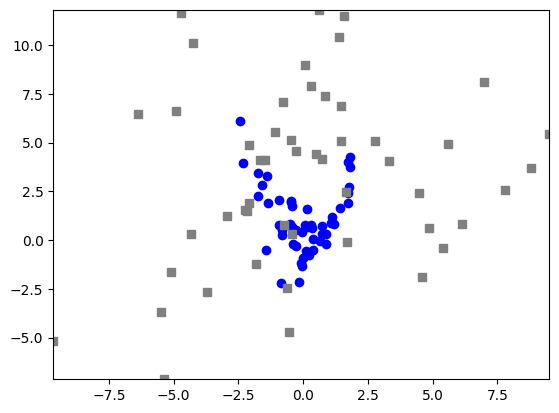

In [14]:
plot_2d(data3, data3[:,2])


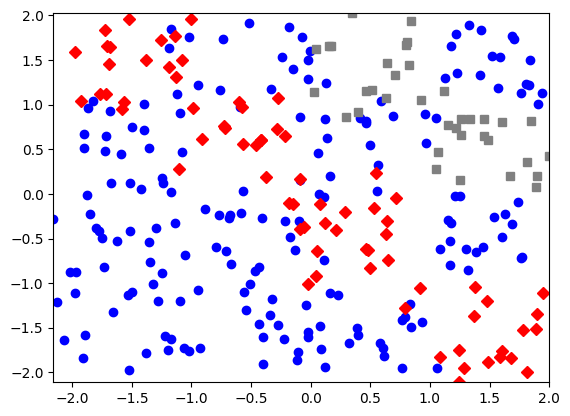

In [15]:
plot_2d(data4, data4[:,2])


## El Método de los $k$-Vecinos Más Cercanos  

### Enfoque Intuitivo  

El algoritmo de los $k$-vecinos más cercanos (**$k$-nn**) es un método intuitivo y fácil de ajustar para abordar problemas de clasificación con cualquier número de etiquetas.  

El principio del algoritmo es simple: para cada nuevo punto $\mathbf{x}$, primero determinamos el conjunto de sus $k$ vecinos más cercanos entre los puntos de entrenamiento, que denotamos como $V_k(\mathbf{x})$ (por supuesto, debemos elegir $1 \leq k \leq n$ para que esto tenga sentido). La clase asignada al nuevo punto $\mathbf{x}$ es entonces la **clase mayoritaria** dentro del conjunto $V_k(\mathbf{x})$. En la siguiente figura se muestra una ilustración del método para el caso de tres clases.

### Ilustración

![Visualización](knn.png "Ejemplo de cómo funciona el método de los k-vecinos más cercanos para valores de parámetro k=5 y k=11. Consideramos tres clases, L=3, representadas respectivamente en negro (y=1), gris (y=2) y blanco (y=3)")

Ejemplo de cómo funciona el método de los k-vecinos más cercanos para valores de parámetro k=5 y k=11. Consideramos tres clases, L=3, representadas respectivamente en negro (y=1), gris (y=2) y blanco (y=3)

1. Proponga una versión adaptada de este método para **regresión**, *es decir*, cuando las observaciones tienen valores reales: $\mathcal{Y} = \mathbb{R}$.

R:  #TODO

## Enfoque Formal

Para definir con precisión el método, primero debemos elegir una distancia $d: \mathbb{R}^p \times \mathbb{R}^p \rightarrow \mathbb{R}$. Para un nuevo punto $\mathbf{x}$, definimos entonces el conjunto de sus $k$-vecinos más cercanos $V_k(\mathbf{x})$ usando esta distancia. Procedemos de la siguiente manera:

Para cada $\mathbf{x} \in \mathbb{R}^p$ y cada $i = 1, \ldots, n$, denotamos $d_i(\mathbf{x})$ como la distancia entre $\mathbf{x}$ y $\mathbf{x}_i$:
$$
d_i(\mathbf{x}) = d(\mathbf{x}_i, \mathbf{x}).
$$

Definimos el estadístico de primer orden $r_1(\mathbf{x})$ como el índice del vecino más cercano a $\mathbf{x}$ entre $\mathbf{x}_1, \ldots, \mathbf{x}_n$, es decir:
$$
r_1(\mathbf{x}) = i^* \quad \text{si y solo si} \quad d_{i^*}(\mathbf{x}) = \min_{1 \le i \le n} d_i(\mathbf{x}).
$$

> **Nota**  
> Si hay múltiples candidatos para el mínimo anterior, los empates se resuelven arbitrariamente (generalmente al azar).

Por inducción, podemos definir el rango $r_k(\mathbf{x})$ para cualquier entero $1 \leq k \leq n$:
$$
r_k(\mathbf{x}) = i^* \quad \text{si y solo si} \quad
d_{i^*}(\mathbf{x}) = \min_{\substack{1 \le i \le n \\ i \notin \{r_1, \ldots, r_{k-1}\}}} d_i(\mathbf{x}).
$$

El conjunto de los $k$-vecinos más cercanos de $\mathbf{x}$ se escribe entonces:
$$
V_k(\mathbf{x}) = \{ \mathbf{x}_{r_1}, \dots, \mathbf{x}_{r_k} \}.
$$

Finalmente, la decisión para clasificar el punto $\mathbf{x}$ se toma por votación mayoritaria, resolviendo el siguiente problema:

$$
\hat{f}_k(\mathbf{x}) \in \arg\max_{y \in \mathcal{Y}} \left( \sum_{j=1}^k \mathbb{1}_{\{Y_{r_j} = y\}} \right).
$$

El módulo `sklearn.neighbors` de **scikit-learn** implementa métodos de clasificación y regresión basados en los $k$-vecinos más cercanos.  
Consulta la documentación: [scikit-learn.neighbors](http://scikit-learn.org/stable/modules/neighbors.html)

2. Completa la clase `KNNClassifier`.  
   Verifica la exactitud de los resultados comparando con la clase `KNeighborsClassifier` de **scikit-learn**.  
   Propón **tu propio método de comparación**.


In [16]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import pairwise_distances
from scipy.stats import mode


class KNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=1):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_ = X
        self.y_ = y
        return self

    def predict(self, X):
        # Calcular distancias entre puntos de test y de entrenamiento
        distances = pairwise_distances(X, self.X_)

        # Encontrar los índices de los k vecinos más cercanos
        neighbors_idx = np.argsort(distances, axis=1)[:, :self.n_neighbors]

        # Obtener las etiquetas correspondientes a esos vecinos
        neighbor_labels = self.y_[neighbors_idx]

        # Calcular la moda (etiqueta más frecuente) para cada punto de prueba
        mode_result = mode(neighbor_labels, axis=1, keepdims=True)
        predictions = mode_result.mode.flatten()

        return predictions


from sklearn import metrics, neighbors

# Conjunto de datos 2
X_train = data2[::2, :2]
Y_train = data2[::2, 2]
X_test = data2[1::2, :2]
Y_test = data2[1::2, 2]

# Entrenar tu implementación
my_knn = KNNClassifier(n_neighbors=3)
my_knn.fit(X_train, Y_train)
y_pred_custom = my_knn.predict(X_test)

# Entrenar sklearn
sklearn_knn = neighbors.KNeighborsClassifier(n_neighbors=3)
sklearn_knn.fit(X_train, Y_train)
y_pred_sklearn = sklearn_knn.predict(X_test)

# Evaluar
print("Exactitud (custom KNN):", metrics.accuracy_score(Y_test, y_pred_custom))
print("Exactitud (sklearn KNN):", metrics.accuracy_score(Y_test, y_pred_sklearn))


# De ahora en adelante utilice la implementación de scikit-learn
plt.ion()

Exactitud (custom KNN): 0.84
Exactitud (sklearn KNN): 0.84


**Nota**: Para ahorrar en tiempo de cómputo, deberás utilizar la implementación de **scikit-learn**!

3. Ejecuta el algoritmo de clasificación en los tres conjuntos de datos de ejemplo,  
   utilizando la **distancia euclidiana clásica**:  
   $$
   d(\mathbf{x}, \mathbf{v}) = \| \mathbf{x} - \mathbf{v} \|_2
   $$

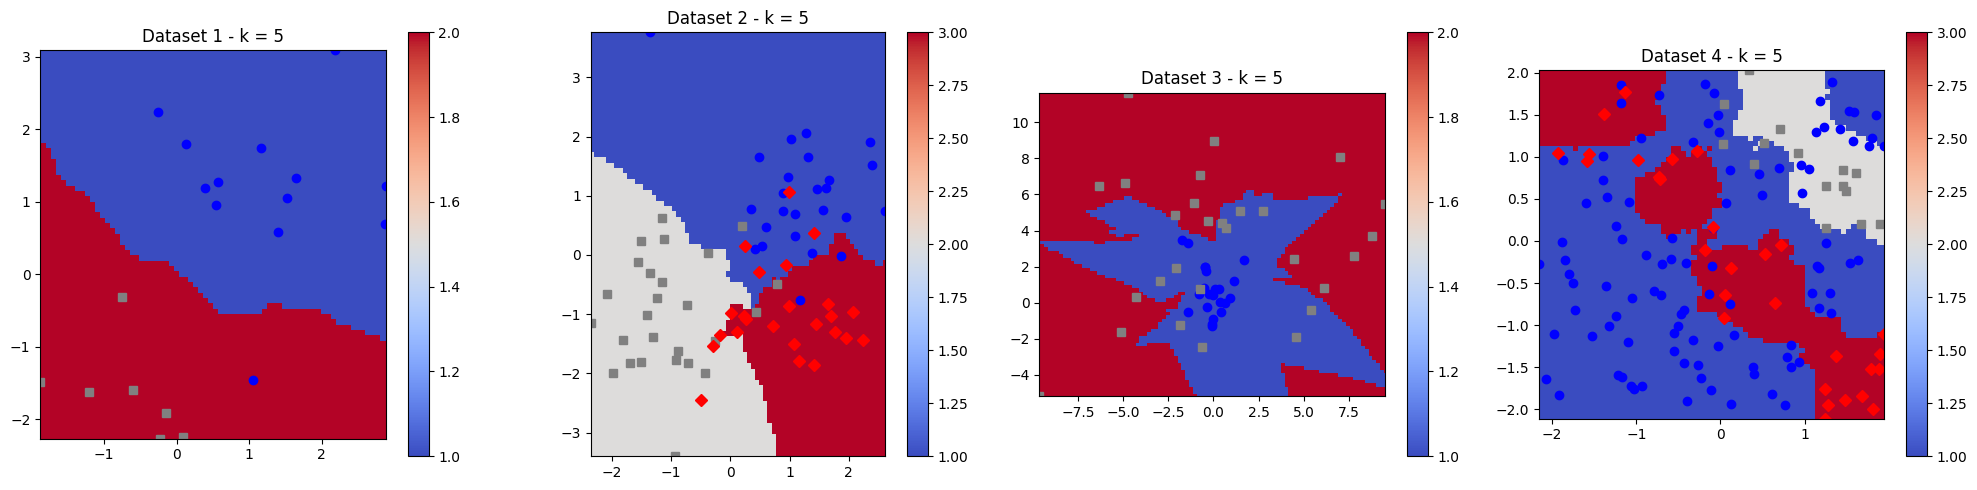

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors

n_neighbors = 5
plt.figure(figsize=(20, 5))
knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean')

for i, data in enumerate([data1, data2, data3, data4]):
    X_train = data[::2, :2]
    Y_train = data[::2, 2]
    X_test = data[1::2, :2]
    Y_test = data[1::2, 2]

    # Entrenar clasificador KNN
    knn.fit(X_train, Y_train)

    # Crear el subplot
    plt.subplot(1, 4, i + 1)

    # Dibujar frontera y puntos
    frontiere(knn.predict, X_test, step=100)
    plot_2d(X_test, Y_test)
    plt.title(f"Dataset {i+1} - k = {n_neighbors}")

plt.tight_layout()
plt.show()


4. Varía el número $k$ de vecinos considerados.  
   - ¿En qué se convierte el método en los casos extremos cuando $k=1$? ¿Y cuando $k=n$?  
   - Muestra estos casos en los datos estudiados.  
   - ¿En qué casos el **límite de decisión es complejo**? ¿**simple**?

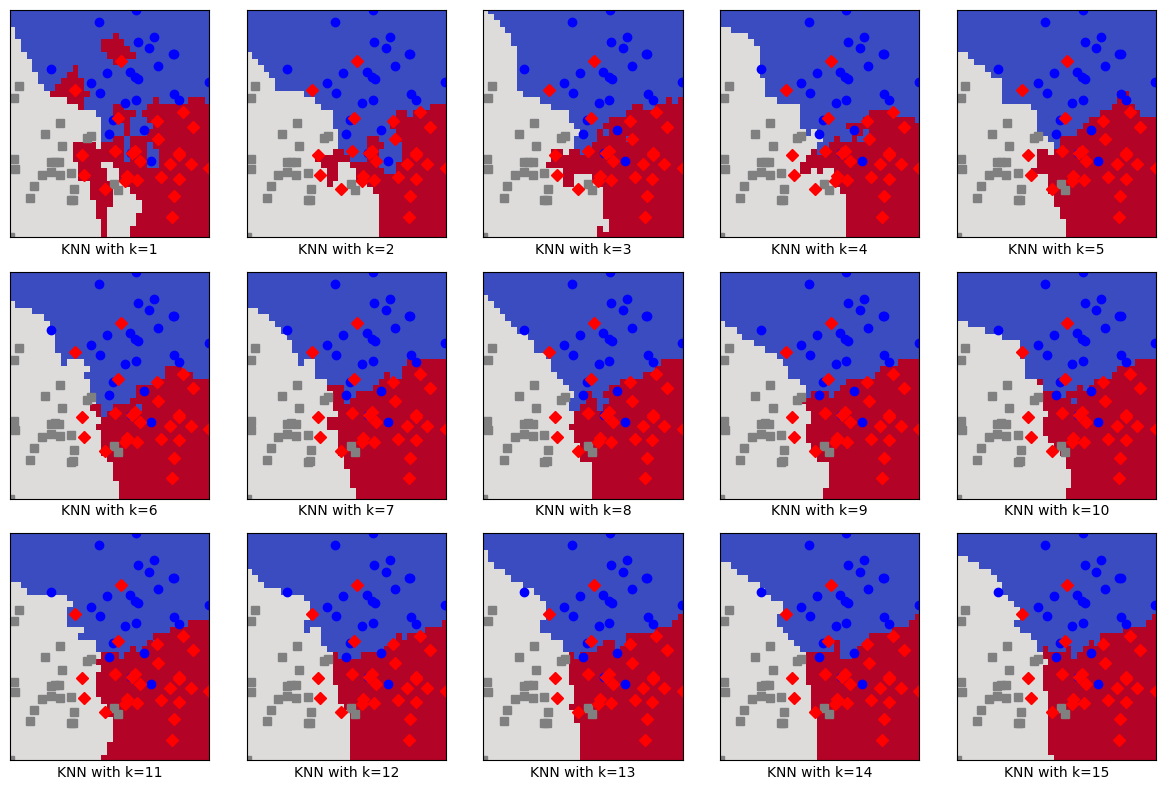

In [18]:
plt.figure(3, figsize=(12, 8))
# Conjunto de datos 2
X_train = data2[::2, :2]
Y_train = data2[::2, 2]
X_test = data2[1::2, :2]
Y_test = data2[1::2, 2]
for n_neighbors in range(1, 16):
    knn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)

    knn.fit(X_train, Y_train)
    plt.subplot(3, 5, n_neighbors)
    plt.xlabel('KNN with k=%d' % n_neighbors)
    plot_2d(X_train, Y_train)
    frontiere(knn.predict, X_train, step=50, tiny=True)
plt.tight_layout()

R: Cuando k = 1, la frontera es irregular y es particularmente aquí cuando el límite de decisión es complejo, ya que se tiene mucho ruido. Por otro lado se espera que en la medida que k crezca para un volumen de datos mayor el modelo deje de aprender y comience a realizar underfitting ya que cada vez aprenderá menos de los datos y las fronteras desaparecerían. Por otro lado podemos observar que sobre k=10 hasta k=15 el modelo es bueno por tanto el límite de decisión es simple.

 5. Una variante ampliamente utilizada consiste en **ponderar los votos** del j-ésimo vecino mediante la siguiente fórmula:  
   $$
   e^{-d_j^2 / h}
   $$
   (donde $h$ controla el nivel de ponderación).

   Esto equivale a reemplazar la ecuación de votación mayoritaria por:

   $$
   \hat{f}_k(\mathbf{x}) \in \arg\max_{y \in \mathcal{Y}} \left( \sum_{j=1}^k \exp\left(-\frac{d_j^2}{h}\right) \mathbb{I}_{\{Y_{r_j} = y\}} \right)
   $$

   - Implementa esta variante en tu clase `KNNClassifier`
   - También impleméntala usando scikit-learn pasando el parámetro `weights` al constructor de `KNeighborsClassifier`
   - Puedes inspirarte en la función `_weight_func` de las pruebas de scikit-learn: [Enlace a prueba de scikit-learn](https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/neighbors/tests/test_neighbors.py)

   - **Prueba el impacto de la elección de $h$** en los límites de clasificación 

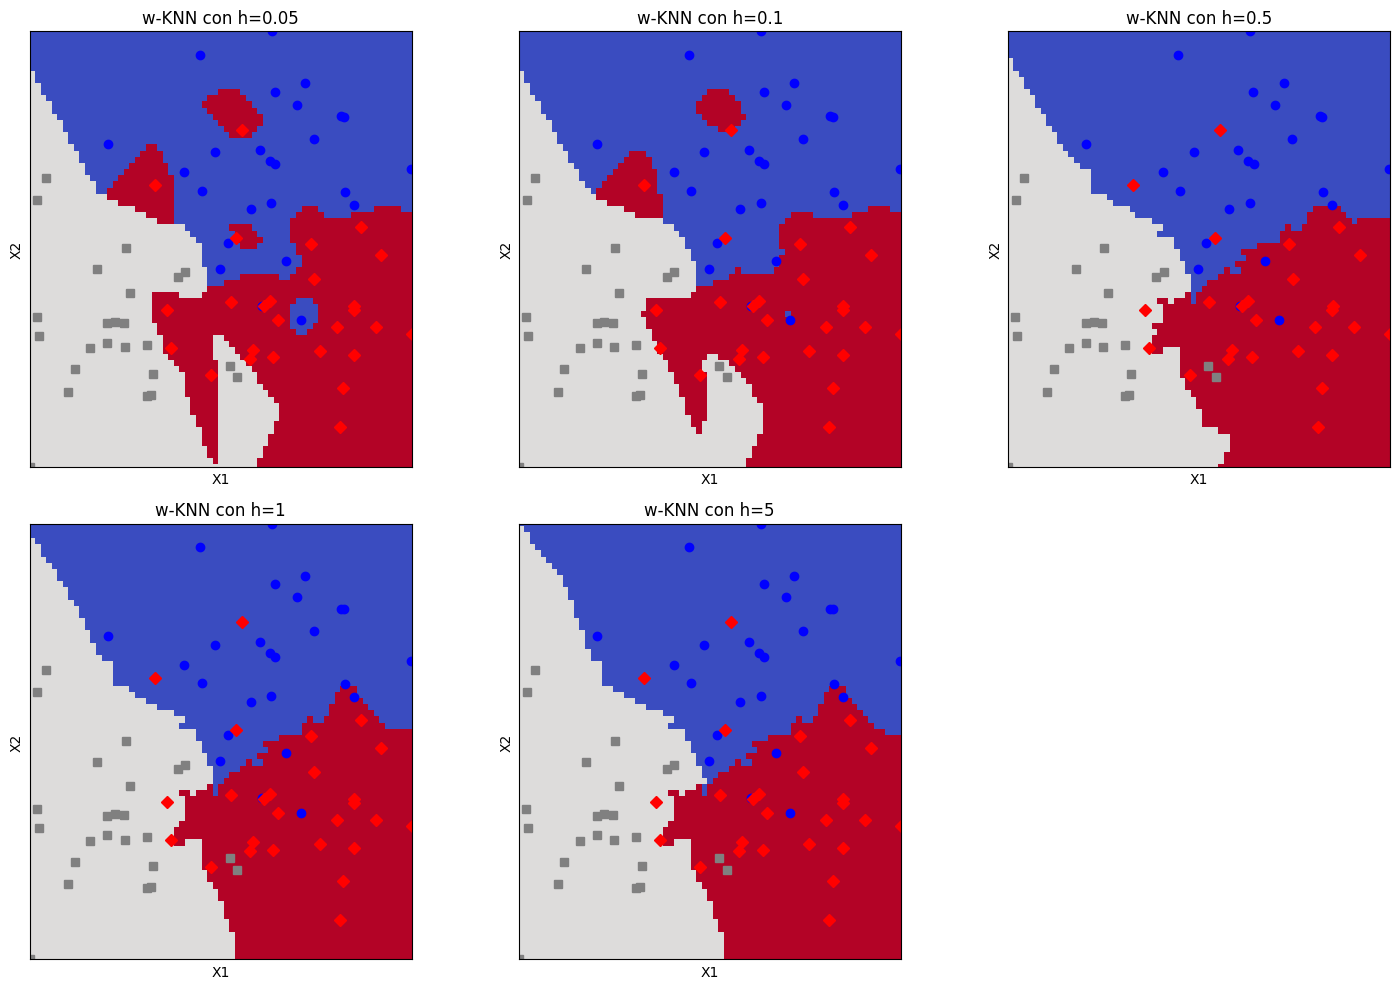

In [19]:
h_values = [0.05, 0.1, 0.5, 1, 5]

# Número de vecinos
n_neighbors = 5

plt.figure(figsize=(15, 10))
for i, h in enumerate(h_values, 1):
    def weight_function(d):
        return np.exp(-np.square(d) / h)

    def weights(dist):
        return np.array([weight_function(d) for d in dist])

    # Clasificador ponderado
    wknn = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights)
    wknn.fit(X_train, Y_train)

    plt.subplot(2, 3, i)
    plot_2d(X_train, Y_train)
    frontiere(wknn.predict, X_train, step=100, tiny=True)
    plt.title(f"w-KNN con h={h}")
    plt.xlabel("X1")
    plt.ylabel("X2")

plt.tight_layout()
plt.show()

Comente sus resultados

R: como h controla el nivel de ponderación, notamos que si h es muy pequeño 0.05 resulta sensible al ruido y no se identifican las fronteras claramente, en h=1 tenemos un modelo más apropidado y ya con h=5 el modelo es suave. La diferencia no es tan notoria por el reducido volumen de datos de h=1 a h=5.

6. ¿Cuál es la **tasa de error** en tus datos de entrenamiento (es decir, la proporción de errores cometidos por el clasificador) cuando $k = 1$?

    Use el método [`score()`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.score)

In [20]:
# Crear clasificador KNN con k=1
knn = neighbors.KNeighborsClassifier(n_neighbors=1)

# Entrenar con los datos de entrenamiento
knn.fit(X_train, Y_train)

# Calcular precisión
accuracy = knn.score(X_test, Y_test)

# Tasa de error = 1 - precisión
error_rate = 1 - accuracy
print(error_rate)

0.21333333333333337


7. Grafica las **curvas de error** en función de $k$ para uno de los conjuntos de datos,  
   con tamaños de muestra $n$ que varíen entre $100$, $500$ y $1000$.

   - ¿Cuál es el mejor valor de $k$?
   - ¿Es siempre el mismo para los diferentes conjuntos de datos?
   - Asegúrate de evaluar el error en los **datos de prueba**.
   - Puedes utilizar la clase proporcionada `ErrorCurve`.

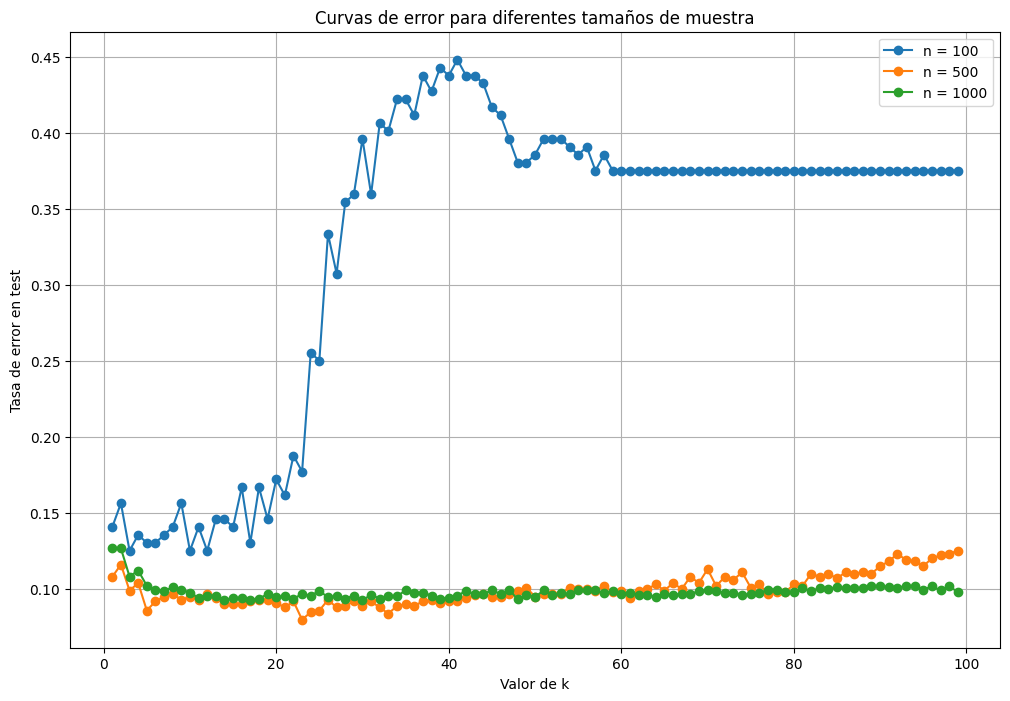

In [21]:
# Preparar
sigma = 0.1
range_n_samples = [100, 500, 1000]
k_range = range(1, 100)

# Función auxiliar para generar los conjuntos de entrenamiento y prueba
def generate_train_test(n, sigma):
    data = rand_checkers(n, n, sigma)
    X_train, Y_train = data[:, :2], data[:, 2]
    data_test = rand_checkers(n, n, sigma)
    X_test, Y_test = data_test[:, :2], data_test[:, 2]
    return X_train, Y_train, X_test, Y_test

from tp_knn_source import ErrorCurve

# Graficar curva de error para cada tamaño de muestra
plt.figure(figsize=(12, 8))
for n_samples in range_n_samples:
    X_train, Y_train, X_test, Y_test = generate_train_test(n_samples, sigma)

    ec = ErrorCurve(k_range=k_range)
    ec.fit_curve(X_train, Y_train, X_test, Y_test)
    ec.plot(label=f"n = {n_samples}")

plt.title("Curvas de error para diferentes tamaños de muestra")
plt.xlabel("Valor de k")
plt.ylabel("Tasa de error en test")
plt.legend()
plt.grid(True)
plt.show()

R: Para muestras grandes (n=500 y n=1000), el mejor valor de k está entre 10 y 40, aproximadamente, donde la tasa de error es más baja. Mientras que para muestras con n = 100, se tiene que la tasa de error en tests es más sensible ante el incremento de k, particularmente se dispara en el rango entre 20 y 40 de k, y luego se mantiene constante a partir de k = 60. Luego se tiene que el mejor k es distinto dependiendo del tamaño de la muestra.

8. En tu opinión, ¿cuáles son las **ventajas** y **desventajas** del método de los vecinos más cercanos?  
   - ¿Tiempo de cálculo?  
   - ¿Escalabilidad?  
   - ¿Interpretabilidad?

R:
Ventajas:
    - Fácilmente interpretable: es posible desarrollar una interpretación a partir de los puntos vecinos y sus caracteristicas.
    - Intuitivo: para clasificar un punto, simplemente se buscan sus k vecinos más cercanos.

Desventajas:
    - Lento: para cada nuevo punto, debe calcular la distancia a todos los puntos de entrenamiento O(n).
    - Escala mal: No escala bien con el tamaño del conjunto de entrenamiento ni con la dimensión del espacio (problema de la maldición de la dimensionalidad).
    - Sensible: Como se observó en el desarrollo anterior si n es pequeño (100) y k aumenta, se hace notar más el error al identificar diferencias.

9. Aplica el método al conjunto de datos **`digits`** con diferentes elecciones de $k \geq 1$. 

    Consulta: [plot_digits_classification.py — scikit-learn](https://scikit-learn.org/stable/auto_examples/classification/plot_digits_classification.html)

<class 'sklearn.utils._bunch.Bunch'>
Score : 0.9254727474972191


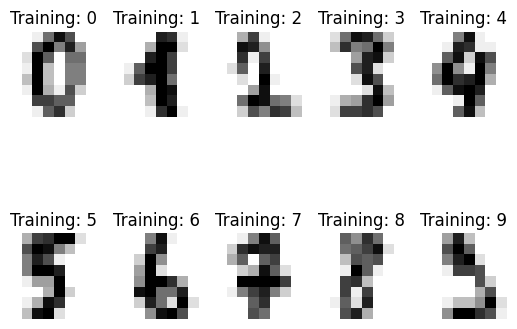

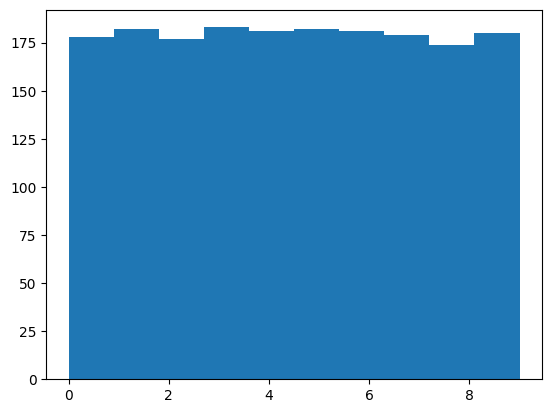

In [22]:
# import sklearn
from sklearn import datasets

# El conjunto de datos de dígitos
digits = datasets.load_digits()

print(type(digits))
# Un Bunch es una subclase de 'dict' (dictionary)
# help(dict)
# vea también "http://docs.python.org/2/library/stdtypes.html#mapping-types-dict"

plt.close(7)
plt.figure(7)
for index, (img, label) in enumerate(list(zip(digits.images, digits.target))[10:20]):
    plt.subplot(2, 5, index + 1)
    plt.axis('off')
    plt.imshow(img, cmap=plt.cm.gray_r, interpolation='None')
    plt.title('Training: %i' % label)

plt.figure()
plt.hist(digits.target)

n_samples = len(digits.data)

X_train = digits.data[:n_samples // 2]
Y_train = digits.target[:n_samples // 2]
X_test = digits.data[n_samples // 2:]
Y_test = digits.target[n_samples // 2:]

knn = neighbors.KNeighborsClassifier(n_neighbors=30)
knn.fit(X_train, Y_train)

score = knn.score(X_test, Y_test)
print('Score : %s' % score)

In [23]:
# TODO : Probar con distintos valores de k y comparar el rendimiento
# Pueden usar ErrorCurve

10. Grafica la **matriz de confusión** $\left( \mathbb{P}\{Y = i, C_k(X) = j\} \right)_{i, j}$ asociada al clasificador $C_k$. 

    Para manejar estas matrices con scikit-learn, consulta: [Ejemplo de matriz de confusión — scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html)

In [24]:
from sklearn.metrics import confusion_matrix

Y_pred = knn.predict(X_test)

# TODO : Graficar la matriz de confusión

11. Propón un **método para seleccionar $k$** e impleméntalo. Puedes utilizar la clase proporcionada `LOOCurve`.

In [25]:
# Revise la clase 'LOOCurve', en el archivo fuente

from tp_knn_source import LOOCurve

loo_curve = LOOCurve(k_range=list(range(1, 50, 5)) + list(range(100, 300, 100)))

# TODO : Graficar LOOCurve

¿De qué forma elegiría usando `LOOCurve` k?

R: